In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
#from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
# distribution of scores from random choice of 5 features
scores=[]
# load data
trainx = pd.read_csv('microarray_train.csv', index_col=0)
trainy = trainx.pop('cancer')

testx = pd.read_csv('microarray_test.csv', index_col=0)
testy = testx.pop('cancer')

for i in range(10**5):
    # pick random features
    randfeat = random.sample(list(trainx.columns), 5)
    train = trainx[randfeat]
    test = testx[randfeat]
    #print(f'shape after features selected: {train.shape}')
    #print(randfeat)
    #print(test.head())

    # model pipeline
    svcpipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(C=1, class_weight='balanced'))
    ])   

    svcpipe.fit(train, trainy)
    scores.append(svcpipe.score(test, testy))
    
print(f'Mean Score: {np.mean(scores)}')
print(f'Median Score: {np.median(scores)}')

Mean Score: 0.6249373529411764
Median Score: 0.6176470588235294


(array([1.4000e+01, 7.5000e+01, 3.9900e+02, 1.6810e+03, 5.0790e+03,
        4.7810e+03, 1.5987e+04, 2.4307e+04, 2.4234e+04, 8.8580e+03,
        9.8440e+03, 3.4730e+03, 1.0350e+03, 2.2000e+02, 1.3000e+01]),
 array([0.20588235, 0.25882353, 0.31176471, 0.36470588, 0.41764706,
        0.47058824, 0.52352941, 0.57647059, 0.62941176, 0.68235294,
        0.73529412, 0.78823529, 0.84117647, 0.89411765, 0.94705882,
        1.        ]),
 <BarContainer object of 15 artists>)

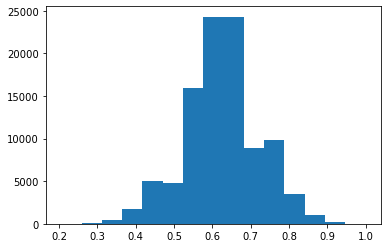

In [3]:
plt.hist(scores, bins=15)

#### What about trying random choice of 5 features after initial filter?

In [4]:
# create metrics df
def generate_metrics(df,target):    
    metrics = pd.DataFrame()
    metrics['var'] = df.var()
    # compute percent of intensity values > 0 for esch feature
    metrics['pctvalpos'] = [sum(df[col]>0)/len(df[col]) for col in df.columns]
    # compute mutual info for features
    metrics['mi'] = mutual_info_classif(df, target, random_state=123)
    
    # compute regular p-values for each feature between ALL/0 and AML/1 
    pval=[]
    for col in df.columns:
        pval.append(stats.ttest_ind(df.loc[target==1,col], df.loc[target==0,col], equal_var=False)[1]) # store p-val
    metrics['pval'] = pval
    
    # compute adjusted p-values for each feature between ALL and AML with permutations 
    pval=[]
    for col in df.columns:
        pval.append(stats.ttest_ind(df.loc[target==1,col], df.loc[target==0,col], \
                                    permutations=2000, random_state=123,equal_var=False)[1]) # store p-val
    metrics['adj_pval'] = pval    

    return metrics

#met = generate_metrics(train, target)
#met.describe()


In [5]:
# drop features based on metrics
def dropfeat(df, metricsdf):
    dropcol = metricsdf[metricsdf['pctvalpos'] < 0.5].index
    #dropcol = metricsdf[metricsdf['adj_pval'] > 0.01].index
    dropcol = dropcol.append(metricsdf[metricsdf['adj_pval'] > 0.0006].index)
    #dropcol = dropcol.append(metricsdf[metricsdf['pval'] > 0.001].index)
    dropcol = dropcol.append(metricsdf[metricsdf['mi'] < 0.4].index)
    
    dropcol = dropcol.unique()
    df = df.drop(dropcol, axis=1)
    #print(df.shape)
    return df

In [6]:
# distribution of scores from random choice of 5 features after metrics filter, but before correlation step
trainx = pd.read_csv('microarray_train.csv', index_col=0)
trainy = trainx.pop('cancer')

testx = pd.read_csv('microarray_test.csv', index_col=0)
testy = testx.pop('cancer')

# label encode target, ALL:0, AML:1
le = LabelEncoder()
trainy = le.fit_transform(trainy)
testy = le.fit_transform(testy)
print(f'classes: {le.classes_}')

# create metrics df, drop features based on metrics
metrics = generate_metrics(trainx, trainy)
trainx = dropfeat(trainx, metrics)
testx = dropfeat(testx, metrics)
print(f'shape after metrics filter: {trainx.shape}')

# find correlated features, drop features
#corrcol = generate_corr(trainx, threshold=0.7, metricsdf=metrics)
#trainx = trainx.drop(corrcol, axis=1)
#testx = testx.drop(corrcol, axis=1)
#print(f'shape after correlation filter: {trainx.shape}')

scores=[]
for i in range(10**5):
    # pick random features
    randfeat = random.sample(list(trainx.columns), 5)
    train = trainx[randfeat]
    test = testx[randfeat]


    # model pipeline
    svcpipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(C=1, class_weight='balanced'))
    ])   

    svcpipe.fit(train, trainy)
    scores.append(svcpipe.score(test, testy))
    
print(f'Mean Score: {np.mean(scores)}')

classes: ['ALL' 'AML']
shape after metrics filter: (38, 12)
Mean Score: 0.8917126470588237


(array([  129.,     0.,     0.,   389.,  1404.,     0.,  6165.,     0.,
        14840.,     0., 31477., 29654.,     0., 11945.,  3997.]),
 array([0.70588235, 0.72352941, 0.74117647, 0.75882353, 0.77647059,
        0.79411765, 0.81176471, 0.82941176, 0.84705882, 0.86470588,
        0.88235294, 0.9       , 0.91764706, 0.93529412, 0.95294118,
        0.97058824]),
 <BarContainer object of 15 artists>)

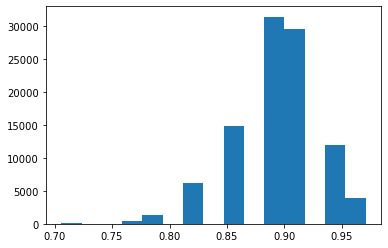

In [7]:
plt.hist(scores, bins=15)

In [8]:
# remaining features
trainx.columns

Index(['D10495_at', 'D88422_at', 'M21551_rna1_at', 'M27891_at', 'M31166_at',
       'M55150_at', 'M77142_at', 'U50136_rna1_at', 'X95735_at', 'Y12670_at',
       'L09209_s_at', 'M27783_s_at'],
      dtype='object')

In [9]:
# gene descriptions of remaining features
gene_info = pd.read_csv('gene_info.csv', index_col=0)
#gene_info.head()
geneidx=[]
for genenum in trainx.columns:
    mask = gene_info['Gene Accession Number'].str.match(genenum)
    geneidx.append(list(gene_info[mask].index)[0])
    
print(geneidx)
gene_info.iloc[geneidx,:]

[172, 759, 1806, 1881, 1925, 2019, 2232, 3319, 4846, 5038, 6040, 6217]


,Gene Description,Gene Accession Number
172,PRKCD Protein kinase C; delta,D10495_at
759,CYSTATIN A,D88422_at
1806,Neuromedin B mRNA,M21551_rna1_at
1881,CST3 Cystatin C (amyloid angiopathy and cerebr...,M27891_at
1925,PTX3 Pentaxin-related gene; rapidly induced by...,M31166_at
2019,FAH Fumarylacetoacetate,M55150_at
2232,NUCLEOLYSIN TIA-1,M77142_at
3319,Leukotriene C4 synthase (LTC4S) gene,U50136_rna1_at
4846,Zyxin,X95735_at
5038,LEPR Leptin receptor,Y12670_at
